## Computing and visualizing ERDS maps for Lee2019 dataset
https://mne.tools/stable/auto_examples/time_frequency/time_frequency_erds.html
### Initiating Lee2019 dataset class


In [1]:
import sys
sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')
from helper_functions import setup_logger, load_procesed_data
from datasets import Lee2019

log = setup_logger("Lee_preprocess")
dataset = Lee2019()
dataset

Dataset:
Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
Sessions per subject: 2
Events: {'left_hand': 2, 'right_hand': 1}
Code: Lee2019 #20
Interval: []
DOI: 
Additional info: paradigms = 'MI','ERP','SSVEP'

epoching was already carried out in lee_run.py, \
tmin = -1.2\
tmax = 5.2\
200ms buffer was added as means of avoiding signal distortions \
autoreject was applied to epochs

__In the original dataset article classification of left/right MI was done on epochs with:__\
tmin = 1.0\
tmax = 3.5

20 channels were chosen over motor cortex:\
'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6','C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6','CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6'\

Bandpass filtered 8-30Hz with a 5th order Butterworth digital filter.




In [2]:
### loading 1 subject data ###

dataset_no = 20
paradigm = "MI"
subject = 44
run = 1
data = load_procesed_data(dataset_no, paradigm, subject, run, include=['epochs_raw'])


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\procesed\20\MI\44\1\s44.01_epochs_raw-epo.fif ...
    Found the data of interest:
        t =   -1200.00 ...    5200.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


In [3]:
data

{'epochs_raw': <EpochsFIF | 100 events (all good), -1.2 – 5.2 s (baseline -1.2 – 0 s), ~327.3 MB, data loaded,
  'left_hand': 50
  'right_hand': 50>}

In [4]:
epochs = data["epochs_raw"]
# epochs_autoreject = data["epochs_raw_autoreject"]

Choosing EEG channels according to article and applying 5th order Butterworth bandpass filter 

In [5]:
def proc_epoch(epochs):
    # List of channels to pick
    channels_to_pick = [
        'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6',
        'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
        'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6'
    ]
    available_channels = epochs.ch_names

    # Pick only these channels from the epochs object
    channels_to_pick_filtered = [ch for ch in channels_to_pick if ch in available_channels]

    # Check if there are any channels left to pick
    if channels_to_pick_filtered:
        
        # Pick only the channels that exist
        epochs_proc = epochs.pick_channels(channels_to_pick_filtered)
    epochs_proc = epochs.copy().filter(l_freq=8, h_freq=30, method='iir', iir_params=dict(order=5, ftype='butter'))
    return epochs_proc

In [6]:
epochs_p = proc_epoch(epochs)
epochs_autoreject_p = proc_epoch(epochs_autoreject)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



### Compute and visualize ERDS maps


In [5]:
epochs_p = epochs


In [7]:
import os
import glob
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from mne.stats import permutation_cluster_1samp_test as pcluster_test
# from helper_functions import combine_images,add_border_and_title

Defining function for ERDS plots

In [ ]:
def plot_erds(epochs,subject,run,extra_mark=None, 
              vmin=-1, vmax=1.5,# set min and max ERDS values in plot 
              baseline=(-1, 0), 
              tmin=-1.0, tmax=5.0, 
              kwargs=None, save=False,plot=True, verbose=True, save_tfr=True):
    
    epochs.pick_channels(['C3','Cz','C4'])

    if not verbose:
        mne.set_log_level('ERROR')

    if kwargs is None:
        kwargs = dict(
            n_permutations=100, 
            step_down_p=0.05, 
            seed=1, 
            buffer_size=None, 
            out_type="mask"
        )
    
    freqs = np.arange(2, 36)  # frequencies from 2-35Hz
    event_ids = epochs.event_id  # {'left_hand': 2, 'right_hand': 1}
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    # Compute time-frequency representation (No changes)
    tfr = epochs.compute_tfr(
        method="multitaper",
        freqs=freqs,
        n_cycles=freqs,
        use_fft=True,
        return_itc=False,
        average=False,
        decim=2,
        n_jobs=-1,
    )
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
    
    if extra_mark == None:
        extra_mark = ''
    elif extra_mark != None:
        extra_mark = extra_mark + "_"
    
    if save_tfr:
        tfr_base_path = os.path.join(os.getcwd(), 'data','tfr','20', f'{subject:02}')
        os.makedirs(tfr_base_path,exist_ok=True)
        tfr_path = os.path.join(tfr_base_path, f's{subject:02}.{run:02}_{extra_mark}tfr_data.h5')
        tfr.save(tfr_path, overwrite=True)

    # Loop over events and plot the ERDS
    for event in event_ids:
        # Select desired epochs for visualization
        tfr_ev = tfr[event]
        fig, axes = plt.subplots(
            1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
        )
        for ch, ax in enumerate(axes[:-1]):  # for each channel
            # Positive clusters
            _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
            # Negative clusters
            _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

            # Combine positive and negative clusters
            c = np.stack(c1 + c2, axis=2)  # Combined clusters
            p = np.concatenate((p1, p2))  # Combined p-values
            mask = c[..., p <= 0.05].any(axis=-1)

            # Plot TFR (ERDS map with masking)
            tfr_ev.average().plot(
                [ch],
                cmap="RdBu",
                cnorm=cnorm,
                axes=ax,
                colorbar=False,
                show=False,
                mask=mask,
                mask_style="mask",
            )

            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # Event marker
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        
        # Colorbar and title
        fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        fig.suptitle(f"ERDS ({event})")
        plt.tight_layout()
        
        if plot:
            plt.show()
        
        if save:
            path = os.path.join(os.getcwd(), 'data', 'plots', 'erds', f'{subject:02}')
            os.makedirs(path, exist_ok=True)
            file_path = os.path.join(path, f's{subject:02}.{run:02}-{event}-ERDS.png')
            plt.savefig(file_path)
            
    if save:
        if extra_mark == None:
            extra_mark = ''
        elif extra_mark != None:
            extra_mark = extra_mark + "_"
        image_paths = glob.glob(os.path.join(path, f's{subject:02}.{run:02}-**-ERDS.png'))
        combined_save_path = os.path.join(path, f's{subject:02}.{run:02}_{extra_mark}ERDS.png')
        
        combine_images(image_paths, combined_save_path, 'vertical')
        add_border_and_title(combined_save_path, combined_save_path, f's{subject:02}.{run:02}_{extra_mark}',
                             border_size=0,title_color='black',title_bg_color='white')
        
    plt.close()
    return tfr

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


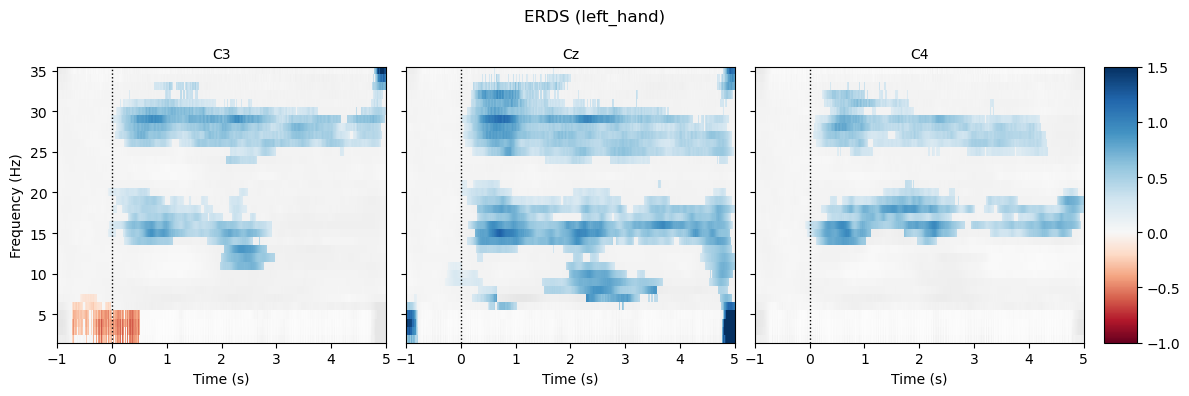

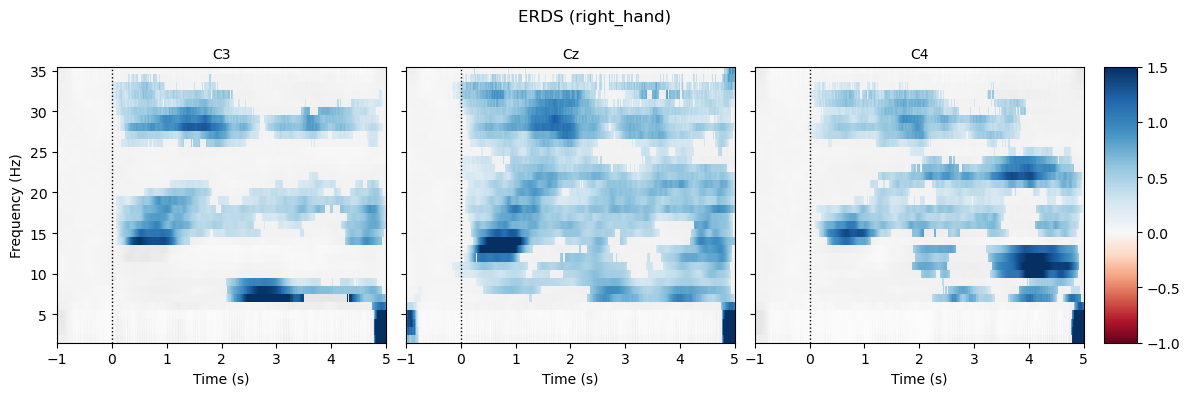

In [9]:
tfr = plot_erds(epochs_p,subject,run,'epochs', verbose=False)

Combined image saved to c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\44\s44.01_autoreject__ERDS.png
Deleted c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\44\s44.01-left_hand-ERDS.png
Deleted c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\44\s44.01-right_hand-ERDS.png
Image saved with border and title at c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\44\s44.01_autoreject__ERDS.png


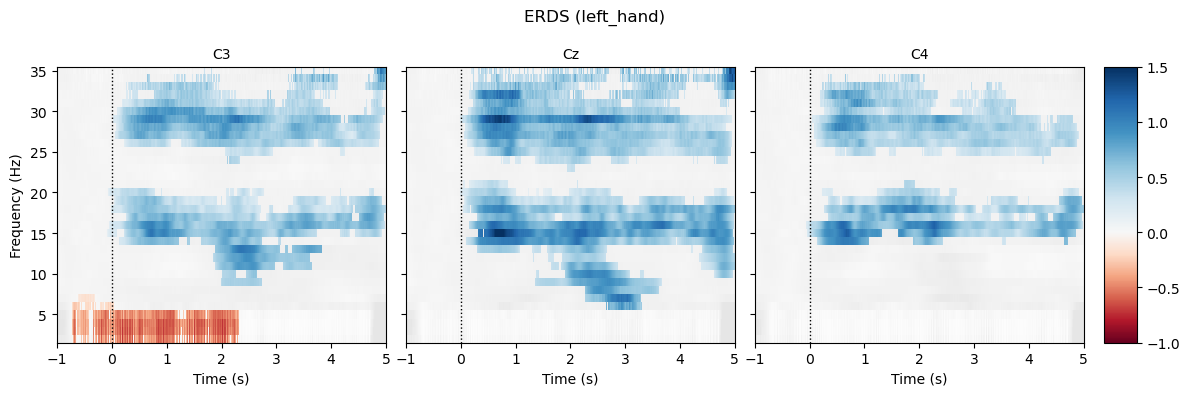

In [17]:
tfr_autoreject = plot_erds(epochs_autoreject_p,subject,run,'autoreject', verbose=False)

In [18]:
tfr

Data type,Power Estimates
Data source,Epochs
Number of epochs,100
Dims,"epoch, channel, freq, time"
Estimation method,multitaper
Number of channels,3
Number of timepoints,3001
Number of frequency bins,34
Frequency range,2.00 – 35.00 Hz


In [19]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C3,Cz,C4
0,-1.000,2.0,0,left_hand,1.975129,2.133607,2.179585
1,-0.998,2.0,0,left_hand,1.974182,2.136228,2.181119
2,-0.996,2.0,0,left_hand,1.976730,2.138724,2.180071
3,-0.994,2.0,0,left_hand,1.984162,2.141425,2.177191
4,-0.992,2.0,0,left_hand,1.997932,2.144718,2.173244


In [10]:
def tfr_lineplot(tfr=None, subject=None,run=None, show=True, save=False, 
                 extra_mark=None, grand=False, grand_tfr_left=None, grand_tfr_right=None):
    # Convert TFR to DataFrame in long format
    
    if grand:
        df = grand_tfr_right.to_data_frame(time_format=None, long_format=True)
        df['condition'] = 'right_hand'

        df_2 = grand_tfr_left.to_data_frame(time_format=None, long_format=True)
        df_2['condition'] = 'left_hand'
        df = pd.concat([df, df_2], ignore_index=True)
    else:
        df = tfr.to_data_frame(time_format=None, long_format=True)

    # Define frequency bands
    freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
    
    # Map frequencies to bands
    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )

    # Filter relevant frequency bands
    freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
    df = df[df.band.isin(freq_bands_of_interest)]
    df["band"] = df["band"].cat.remove_unused_categories()

    # Order channels
    df["channel"] = df["channel"].cat.reorder_categories(["C3", "Cz", "C4"], ordered=True)

    # Create the FacetGrid plot
    g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
    g.map(sns.lineplot, "time", "value", "condition", n_boot=10)

    # Add vertical and horizontal reference lines
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)

    # Set plot limits and labels
    g.set(ylim=(None, 1.5))
    g.set_axis_labels("Time (s)", "ERDS")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    
    # Add a legend
    g.add_legend(ncol=2, loc="lower center")
    
    # Adjust the subplot layout
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    
    # Save the plot if requested
    if save:
        if extra_mark == None:
            extra_mark = ''
        elif extra_mark != None:
            extra_mark = extra_mark + "_"
            
        path = os.path.join(os.getcwd(), 'data', 'plots', 'erds', f'{subject:02}')
        os.makedirs(path, exist_ok=True)
        save_path = os.path.join(path, f's{subject:02}.{run:02}_{extra_mark}ERDS_lineplot.png')
        g.savefig(save_path)
        add_border_and_title(save_path, save_path, f's{subject:02}.{run:02}_{extra_mark}',
                             border_size=0,title_color='black',title_bg_color='white')
        
    # Show the plot if requested
    if show:
        plt.show()

    # Close the plot to avoid memory issues with multiple plots
    plt.close()


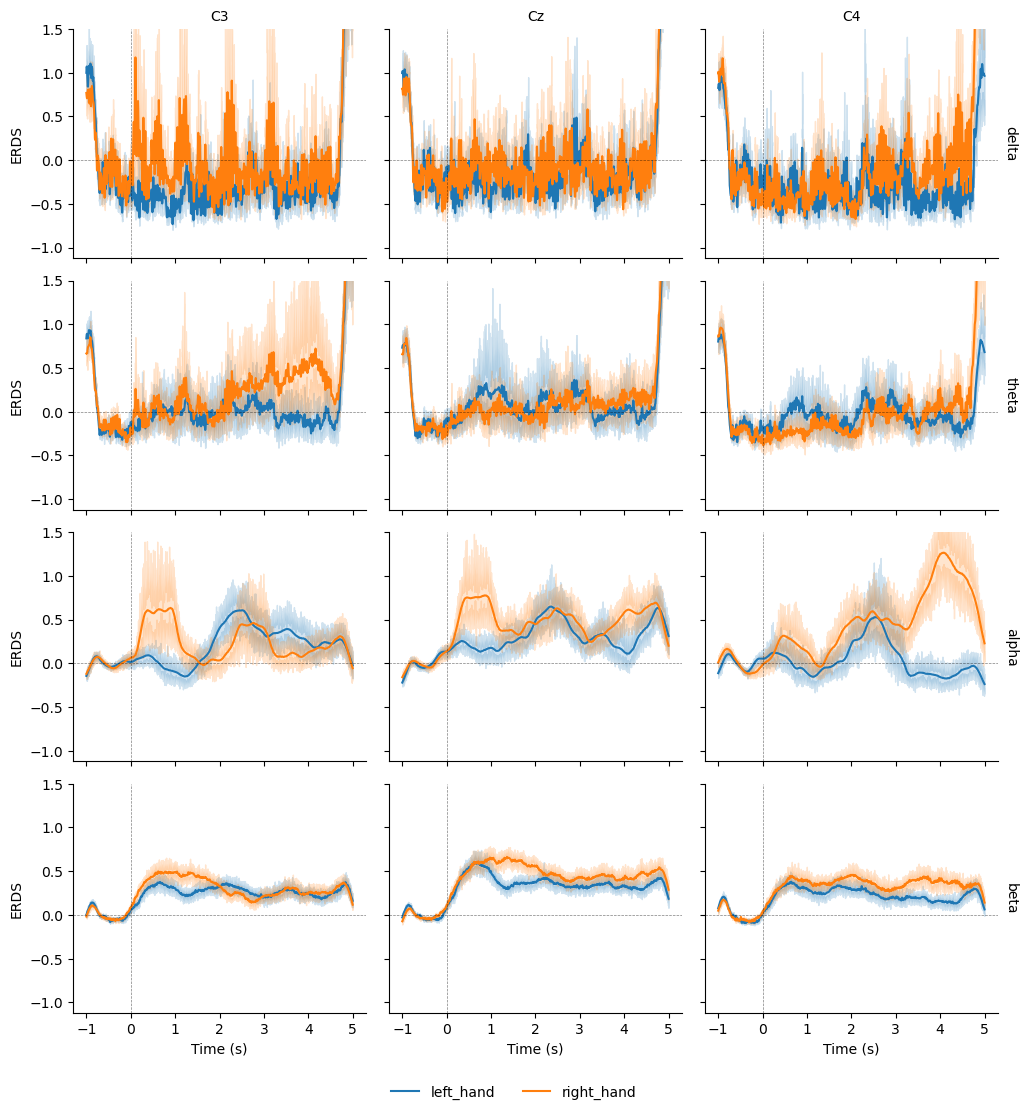

In [11]:
tfr_lineplot(tfr, extra_mark='epochs')

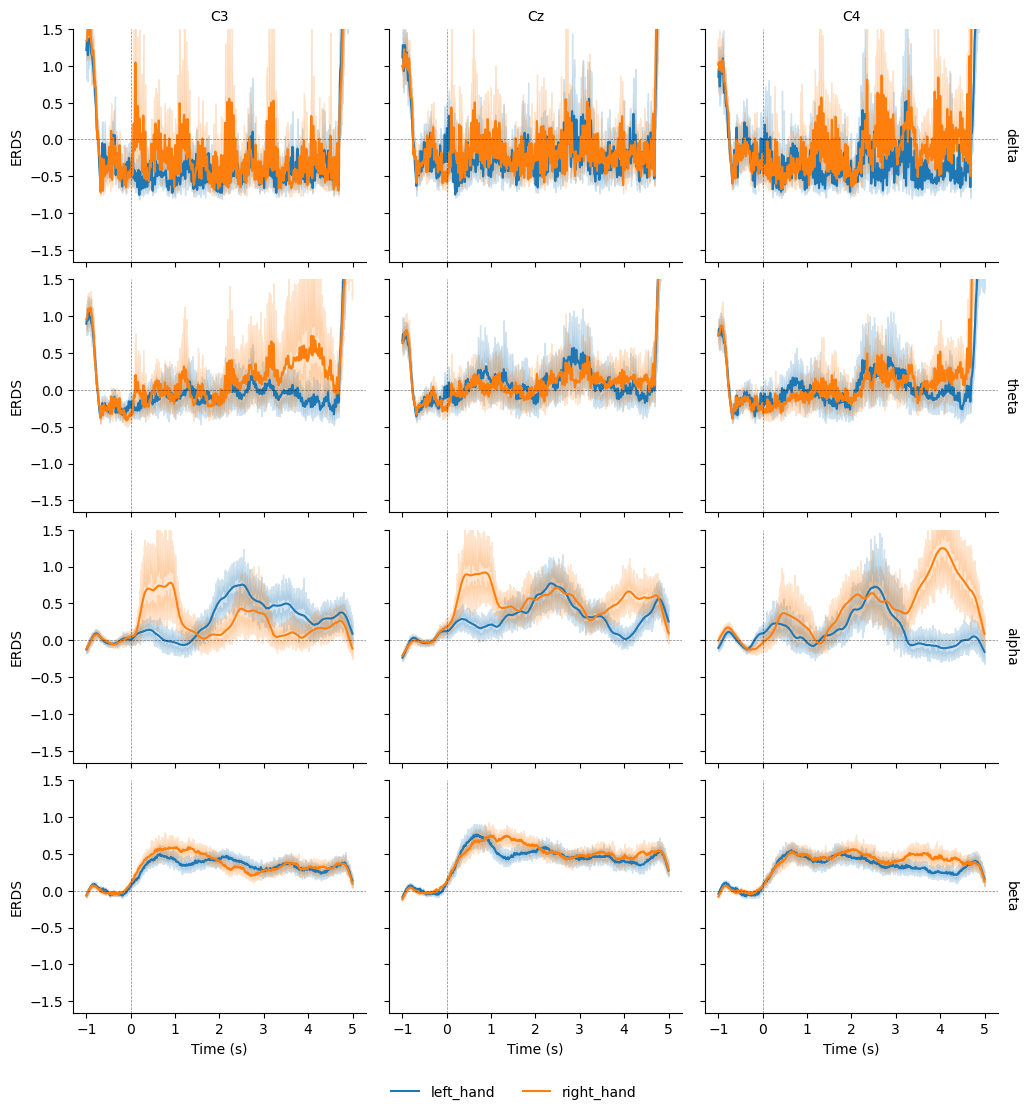

In [22]:
tfr_lineplot(tfr_autoreject, extra_mark='autoreject')

In [25]:
def tfr_violin(tfr,subject=None,run=None,show=True, save=False, extra_mark=None):
    
    df = tfr.to_data_frame(time_format=None, long_format=True)
    
    # Define frequency bands
    freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
    
    # Map frequencies to bands
    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )

    # Filter relevant frequency bands
    freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
    df = df[df.band.isin(freq_bands_of_interest)]
    df["band"] = df["band"].cat.remove_unused_categories()

    # Order channels
    df["channel"] = df["channel"].cat.reorder_categories(["C3", "Cz", "C4"], ordered=True)
    df_mean = (
        df.query("time > 1")
        .groupby(["condition", "epoch", "band", "channel"], observed=False)[["value"]]
        .mean()
        .reset_index()
    )

    g = sns.FacetGrid(
        df_mean, col="condition", col_order=["left_hand", "right_hand"], margin_titles=True
    )
    g = g.map(
        sns.violinplot,
        "channel",
        "value",
        "band",
        cut=0,
        palette="deep",
        order=["C3", "Cz", "C4"],
        hue_order=freq_bands_of_interest,
        linewidth=0.5,
    ).add_legend(ncol=4, loc="lower center")
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, **axline_kw)
    g.set_axis_labels("", "ERDS")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
    
    if save:
        if extra_mark == None:
            extra_mark = ''
        elif extra_mark != None:
            extra_mark = extra_mark + "_"
            
        path = os.path.join(os.getcwd(), 'data', 'plots', 'erds', f'{subject:02}')
        os.makedirs(path, exist_ok=True)
        save_path = os.path.join(path, f's{subject:02}.{run:02}_{extra_mark}ERDS_violin.png')
        g.savefig(save_path)
        add_border_and_title(save_path, save_path, f's{subject:02}.{run:02}_{extra_mark}',
                             border_size=0,title_color='black',title_bg_color='white')
        
    # Show the plot if requested
    if show:
        plt.show()

    # Close the plot to avoid memory issues with multiple plots
    plt.close()

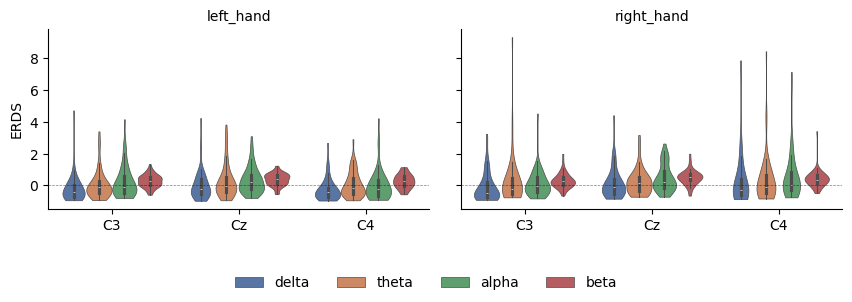

In [26]:
tfr_violin(tfr, extra_mark='epochs')

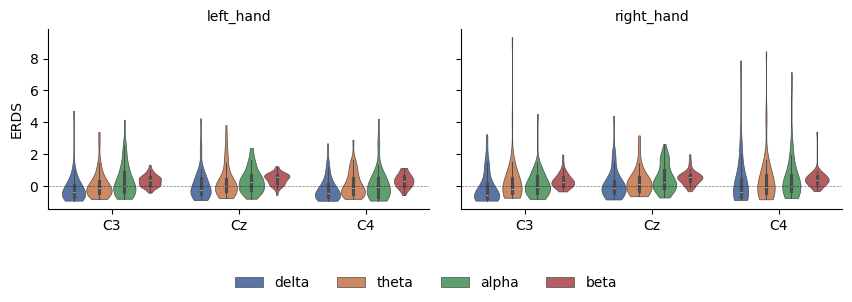

In [27]:
tfr_violin(tfr_autoreject, extra_mark='autoreject')

Loading tfr data for averaged tfr lineplot

In [18]:
import sys
sys.path.append('c:\\Users\\rokas\\Documents\\BCI\\mi-bci\\code')

import os
import glob
import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import setup_logger, add_border_and_title
log = setup_logger("Lee_preprocess")

In [5]:
paths_epo = []
paths_autoreject = []

for subject in range(1,55):
    for run in [1,2]:
        try:
            tfr_path_epo = glob.glob(os.path.join(os.getcwd(), 
                                                  'data','tfr','20',f'{subject:02}',f's{subject:02}.{run:02}_epochs*.h5'))
            tfr_path_auto = glob.glob(os.path.join(os.getcwd(), 
                                                   'data','tfr','20',f'{subject:02}',f's{subject:02}.{run:02}_autoreject*.h5'))
            paths_epo.append(tfr_path_epo)
            paths_autoreject.append(tfr_path_auto)

        except Exception as e:
            # Log the error and continue with the next iteration
            log.error(f"Error processing subject {subject}, run {run}")
            log.error(f"Error details: {e}")
            continue
tfr_paths_epo = [path for path in paths_epo if path]
tfr_paths_autoreject = [path for path in paths_autoreject if path]


First epochs without autoreject filtering

In [ ]:
tfrs = []
tfr_right = []
tfr_left = []
for tfr_file in tfr_paths_epo:
    tfr = mne.time_frequency.read_tfrs(tfr_file[0])  # Reading the first object from the list
    tfr_left.append(tfr['left_hand'].average())
    tfr_right.append(tfr['right_hand'].average())

    tfrs.append(tfr)

In [7]:
wgrand_tfr_epo_right =  mne.grand_average(tfr_right)

Identifying common channels ...
Identifying common channels ...


Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Image saved with border and title at c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\00\s00.00_grand_epo_ERDS_lineplot.png


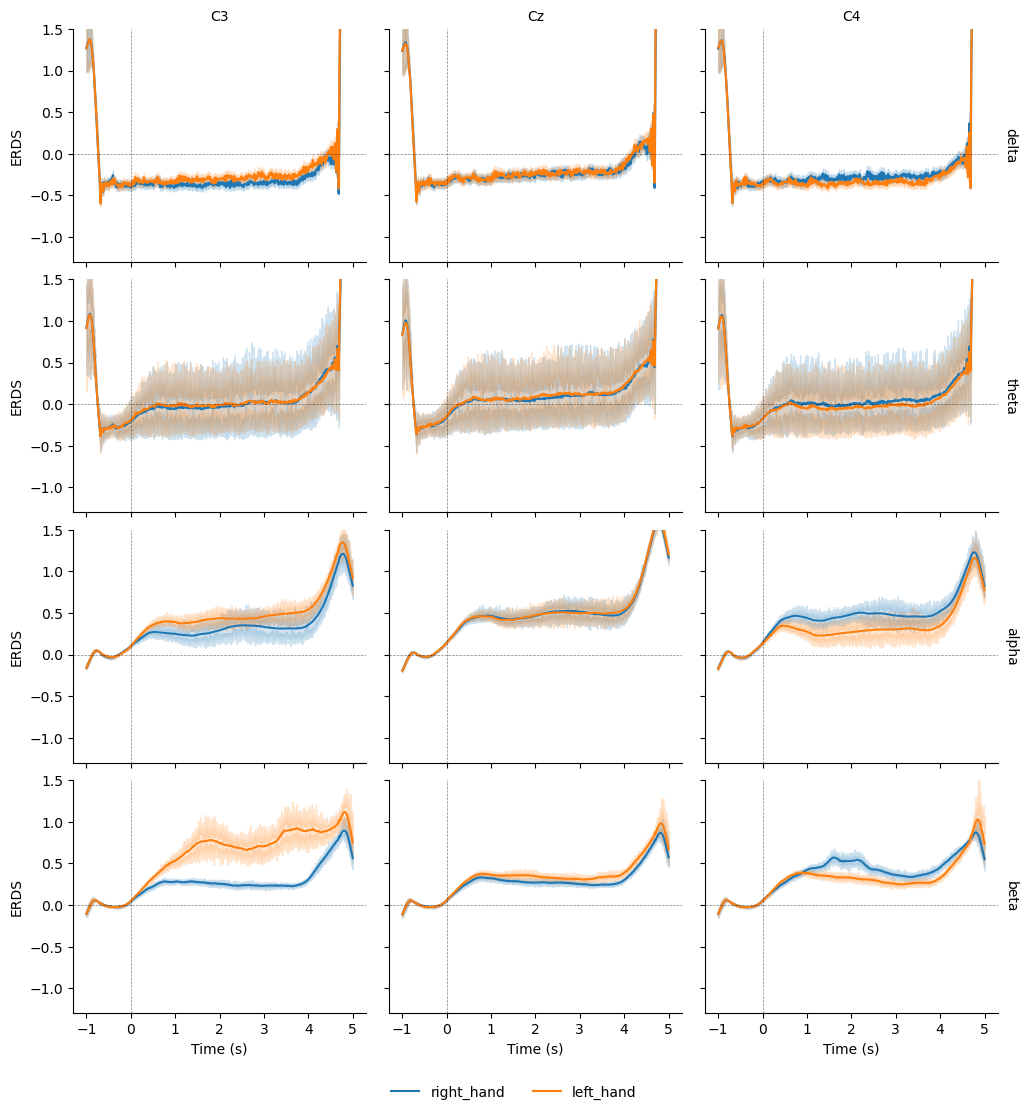

In [19]:
tfr_lineplot(show=True, grand=True, grand_tfr_left=grand_tfr_epo_left, grand_tfr_right=grand_tfr_epo_right, 
             save=True,subject=0,run=0, extra_mark='grand_epo')

Now for epochs cleaned with autoreject

In [ ]:
tfrs = []
tfr_right = []
tfr_left = []
for tfr_file in tfr_paths_autoreject:
    tfr = mne.time_frequency.read_tfrs(tfr_file[0])  # Reading the first object from the list
    tfr_left.append(tfr['left_hand'].average())
    tfr_right.append(tfr['right_hand'].average())

    tfrs.append(tfr)
grand_tfr_epo_left = mne.grand_average(tfr_left)
grand_tfr_epo_right =  mne.grand_average(tfr_right)

Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Image saved with border and title at c:\Users\rokas\Documents\BCI\mi-bci\data\plots\erds\00\s00.00_grand_epo_ERDS_lineplot.png


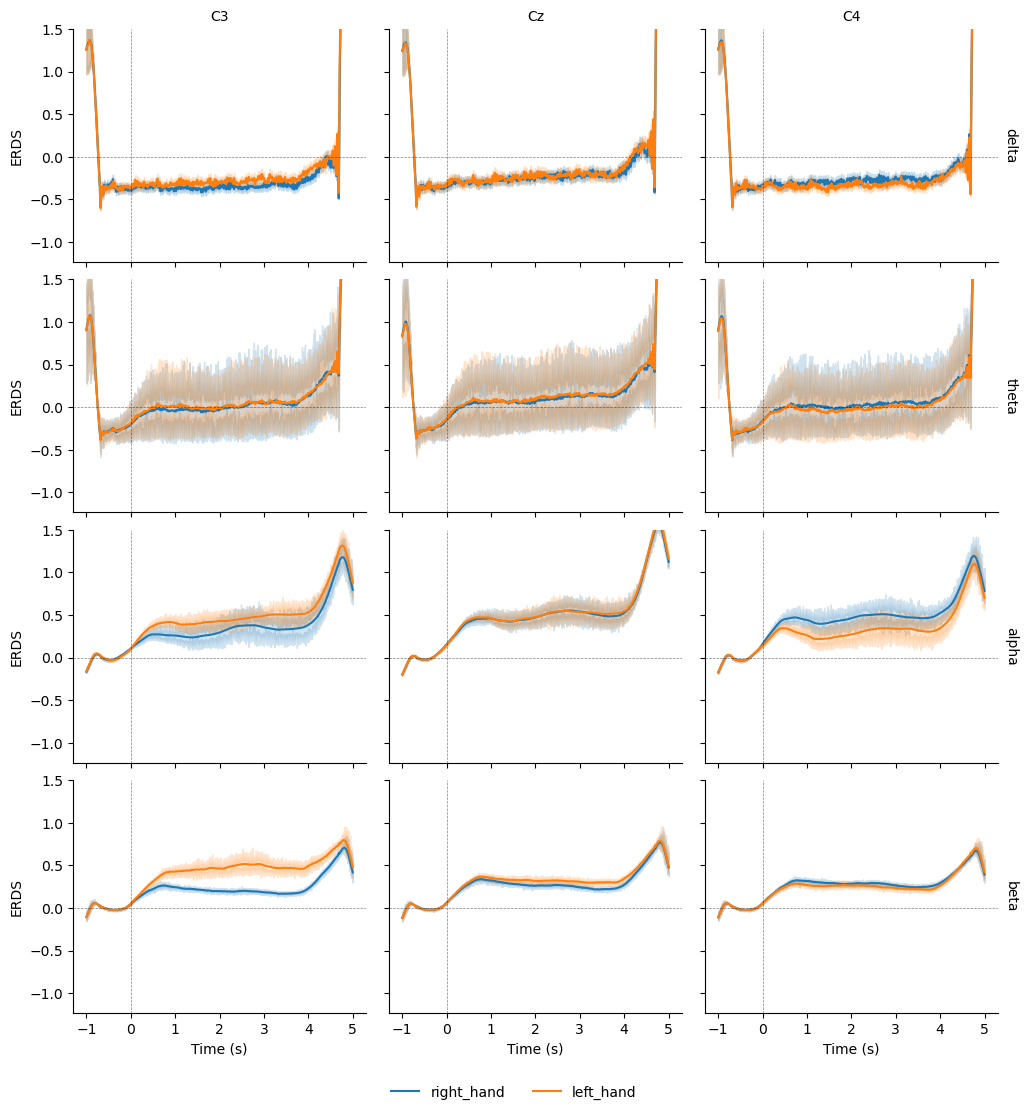

In [21]:
tfr_lineplot(show=True, grand=True, grand_tfr_left=grand_tfr_epo_left, grand_tfr_right=grand_tfr_epo_right, 
             save=True,subject=0,run=0, extra_mark='grand_epo')